# Projet Deep Learning — Partie 4

## Attention Rollout, Heatmaps & IoU

### Objectif
Analyser **TOUS les modèles** (Partie 1 : A/B/C1/C2 + Partie 2 : même résolution) et rapporter :
- **Moyenne et écart-type de l'IoU** sur validation
- **Heatmaps** montrant où le modèle regarde

---

## 1. Configuration et imports

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


import config
from dataloader import get_dataloaders
from model import CrossViTHerbarium
from model_same_res import CrossViTSameResolution
from attention_rollout import (
    AttentionHook, attention_rollout, rollout_to_heatmap,
    compute_iou, visualize_attention
)

device = config.DEVICE
print(f"Device: {device}")

Device: cuda


c:\Users\Roméo\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Définir les modèles à analyser

In [2]:

models_config = [
    
    {"name": "Partie 2 - Même résolution", "checkpoint": "checkpoints/part2_same_res_iou_best.pth", 
     "model_type": "CrossViTSameResolution", "mode": None},
    {"name": "Partie 1 - Config A", "checkpoint": "checkpoints/part1_A_best.pth", 
     "model_type": "CrossViTHerbarium", "mode": "A"},
    {"name": "Partie 1 - Config B", "checkpoint": "checkpoints/part1_B_best.pth", 
     "model_type": "CrossViTHerbarium", "mode": "B"},
    {"name": "Partie 1 - Config C1", "checkpoint": "checkpoints/part1_C1_best.pth", 
     "model_type": "CrossViTHerbarium", "mode": "C1"},
    {"name": "Partie 1 - Config C2", "checkpoint": "checkpoints/part1_C2_best.pth", 
     "model_type": "CrossViTHerbarium", "mode": "C2"},
    

    {"name": "Partie 2 - Même résolution", "checkpoint": "checkpoints/part2_same_res_best.pth", 
     "model_type": "CrossViTSameResolution", "mode": None},
]

print(f"{len(models_config)} modèles à analyser")

6 modèles à analyser


## 3. Fonction de chargement des modèles

In [3]:
def load_model(config_dict):
    """Charge un modèle depuis son checkpoint."""
    model_type = config_dict["model_type"]
    checkpoint_path = config_dict["checkpoint"]
    

    if model_type == "CrossViTHerbarium":
        model = CrossViTHerbarium(mode=config_dict["mode"], pretrained=False)
    elif model_type == "CrossViTSameResolution":
        model = CrossViTSameResolution(
            img_size=224, patch_size=16, num_classes=2,
            embed_dim=256, depth=4, num_heads=8
        )
    else:
        raise ValueError(f"Type de modèle inconnu: {model_type}")
    
    model = model.to(device)
    
 
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        f1 = checkpoint.get('val_f1', checkpoint.get('f1', 0))
        print(f"  ✅ {config_dict['name']} chargé (F1: {f1:.4f})")
    else:
        print(f"  ⚠️  {checkpoint_path} non trouvé")
        return None
    
    model.eval()
    return model

print(" Fonction de chargement prête")

 Fonction de chargement prête


## 4. Préparer les données

In [4]:
train_loader, val_loader = get_dataloaders(img_size=224, batch_size=8)
print(f"Dataset chargé: {len(val_loader.dataset)} images de validation")

Dataset : 898 images | Train : 718 | Val : 180
Dataset chargé: 180 images de validation


## 5. Fonction de génération de heatmap

In [5]:
def generate_heatmap_for_sample(model, batch, device, patch_size=16):
    """
    Génère la heatmap pour un batch donné.
    
    Returns:
        heatmaps : (B, H, W) tensor
        logits : (B, num_classes) tensor
    """
   
    hook = AttentionHook()
    hook.register(model)
    
    
    original = batch["original"].to(device)
    segmented = batch["segmented"].to(device)
    
    with torch.no_grad():
        logits = model(original, segmented)
    
  
    cls_attn = attention_rollout(hook.attention_maps)
    
   
    heatmap = rollout_to_heatmap(cls_attn, img_size=224, patch_size=patch_size)
    
   
    hook.remove()
    
    return heatmap, logits

print(" Fonction de génération de heatmap prête")

 Fonction de génération de heatmap prête


## 6. Calculer IoU pour tous les modèles

On calcule l'IoU sur tout le dataset de validation pour chaque modèle.

In [6]:

results = []

for model_config in models_config:
    print(f"\n{'='*70}")
    print(f"Analyse de : {model_config['name']}")
    print(f"{'='*70}")
    
 
    model = load_model(model_config)
    if model is None:
        print(f"  Modèle non disponible, passage au suivant")
        continue
    
   
    all_iou = []
    iou_with_spines = []
    iou_without_spines = []
    
    print(f"Calcul des IoU...")
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="  IoU computation", leave=False):
            try:
              
                heatmap, logits = generate_heatmap_for_sample(model, batch, device)
                
                mask = batch["mask"]
                labels = batch["label"]
                
               
                for i in range(heatmap.shape[0]):
                    iou = compute_iou(heatmap[i].cpu(), mask[i].cpu())
                    iou_val = iou.item()
                    
                    all_iou.append(iou_val)
                    
                    if labels[i].item() == 1:
                        iou_with_spines.append(iou_val)
                    else:
                        iou_without_spines.append(iou_val)
            except Exception as e:
                print(f"\n Erreur : {e}")
                continue
    

    if all_iou:
        mean_iou = np.mean(all_iou)
        std_iou = np.std(all_iou)
        median_iou = np.median(all_iou)
        
        print(f"\n Résultats :")
        print(f"   Moyenne IoU: {mean_iou:.4f} ± {std_iou:.4f}")
        print(f"   Médiane IoU: {median_iou:.4f}")
        print(f"   Min/Max: {np.min(all_iou):.4f} / {np.max(all_iou):.4f}")
        
        results.append({
            "Modèle": model_config["name"],
            "Moyenne IoU": mean_iou,
            "Écart-type IoU": std_iou,
            "Médiane IoU": median_iou,
            "IoU Avec épines": np.mean(iou_with_spines) if iou_with_spines else 0,
            "IoU Sans épines": np.mean(iou_without_spines) if iou_without_spines else 0,
        })
    else:
        print(f"  Aucun IoU calculé")

print(f"\n Analyse terminée pour {len(results)} modèles")


Analyse de : Partie 2 - Même résolution
  ✅ Partie 2 - Même résolution chargé (F1: 0.8241)
Calcul des IoU...



 Résultats :
   Moyenne IoU: 0.5061 ± 0.1330
   Médiane IoU: 0.5239
   Min/Max: 0.0000 / 0.7814

Analyse de : Partie 1 - Config A
  ✅ Partie 1 - Config A chargé (F1: 0.9749)
Calcul des IoU...


  IoU computation:   4%|▍         | 1/23 [00:03<01:27,  3.98s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:   9%|▊         | 2/23 [00:08<01:28,  4.23s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  13%|█▎        | 3/23 [00:11<01:17,  3.88s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  17%|█▋        | 4/23 [00:14<01:02,  3.29s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  22%|██▏       | 5/23 [00:16<00:53,  2.98s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  26%|██▌       | 6/23 [00:20<00:54,  3.19s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  30%|███       | 7/23 [00:23<00:49,  3.07s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  35%|███▍      | 8/23 [00:26<00:47,  3.16s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  39%|███▉      | 9/23 [00:30<00:46,  3.29s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  43%|████▎     | 10/23 [00:33<00:42,  3.28s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  48%|████▊     | 11/23 [00:37<00:41,  3.44s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  52%|█████▏    | 12/23 [00:39<00:35,  3.19s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  57%|█████▋    | 13/23 [00:43<00:35,  3.51s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  61%|██████    | 14/23 [00:47<00:30,  3.41s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  65%|██████▌   | 15/23 [00:50<00:27,  3.46s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  70%|██████▉   | 16/23 [00:54<00:24,  3.56s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  74%|███████▍  | 17/23 [00:57<00:20,  3.48s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  78%|███████▊  | 18/23 [01:01<00:18,  3.67s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  83%|████████▎ | 19/23 [01:05<00:14,  3.75s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  87%|████████▋ | 20/23 [01:08<00:10,  3.34s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  91%|█████████▏| 21/23 [01:12<00:06,  3.48s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  96%|█████████▌| 22/23 [01:14<00:03,  3.29s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches

 Résultats :
   Moyenne IoU: 0.1145 ± 0.1147
   Médiane IoU: 0.0798
   Min/Max: 0.0001 / 0.5936

Analyse de : Partie 1 - Config B


  ✅ Partie 1 - Config B chargé (F1: 0.9694)
Calcul des IoU...


  IoU computation:   4%|▍         | 1/23 [00:03<01:23,  3.79s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:   9%|▊         | 2/23 [00:08<01:25,  4.05s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  13%|█▎        | 3/23 [00:11<01:16,  3.81s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  17%|█▋        | 4/23 [00:13<01:02,  3.27s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  22%|██▏       | 5/23 [00:16<00:53,  2.96s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  26%|██▌       | 6/23 [00:20<00:54,  3.19s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  30%|███       | 7/23 [00:22<00:49,  3.09s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  35%|███▍      | 8/23 [00:26<00:47,  3.15s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  39%|███▉      | 9/23 [00:29<00:45,  3.27s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  43%|████▎     | 10/23 [00:32<00:42,  3.26s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  48%|████▊     | 11/23 [00:36<00:41,  3.42s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  52%|█████▏    | 12/23 [00:39<00:35,  3.19s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  57%|█████▋    | 13/23 [00:43<00:35,  3.58s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  61%|██████    | 14/23 [00:47<00:31,  3.48s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  65%|██████▌   | 15/23 [00:50<00:28,  3.53s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  70%|██████▉   | 16/23 [00:54<00:25,  3.62s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  74%|███████▍  | 17/23 [00:57<00:21,  3.51s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  78%|███████▊  | 18/23 [01:01<00:18,  3.66s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  83%|████████▎ | 19/23 [01:05<00:14,  3.73s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  87%|████████▋ | 20/23 [01:08<00:10,  3.34s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  91%|█████████▏| 21/23 [01:11<00:06,  3.47s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  96%|█████████▌| 22/23 [01:14<00:03,  3.25s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches

 Résultats :
   Moyenne IoU: 0.4819 ± 0.1308
   Médiane IoU: 0.4996
   Min/Max: 0.0867 / 0.7901

Analyse de : Partie 1 - Config C1


  ✅ Partie 1 - Config C1 chargé (F1: 0.9592)
Calcul des IoU...


  IoU computation:   4%|▍         | 1/23 [00:04<01:42,  4.68s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:   9%|▊         | 2/23 [00:09<01:34,  4.50s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  13%|█▎        | 3/23 [00:12<01:20,  4.01s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  17%|█▋        | 4/23 [00:14<01:03,  3.36s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  22%|██▏       | 5/23 [00:17<00:54,  3.02s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  26%|██▌       | 6/23 [00:20<00:54,  3.23s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  30%|███       | 7/23 [00:23<00:50,  3.14s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  35%|███▍      | 8/23 [00:27<00:51,  3.41s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  39%|███▉      | 9/23 [00:32<00:51,  3.66s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  43%|████▎     | 10/23 [00:35<00:48,  3.74s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  48%|████▊     | 11/23 [00:40<00:47,  3.95s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  52%|█████▏    | 12/23 [00:43<00:41,  3.75s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  57%|█████▋    | 13/23 [00:48<00:41,  4.19s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  61%|██████    | 14/23 [00:52<00:36,  4.04s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  65%|██████▌   | 15/23 [00:56<00:33,  4.13s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  70%|██████▉   | 16/23 [01:01<00:29,  4.26s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  74%|███████▍  | 17/23 [01:05<00:24,  4.13s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  78%|███████▊  | 18/23 [01:10<00:21,  4.30s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  83%|████████▎ | 19/23 [01:14<00:17,  4.38s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  87%|████████▋ | 20/23 [01:17<00:11,  3.98s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  91%|█████████▏| 21/23 [01:21<00:08,  4.06s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  96%|█████████▌| 22/23 [01:25<00:03,  3.81s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches

 Résultats :
   Moyenne IoU: 0.4594 ± 0.1507
   Médiane IoU: 0.4802
   Min/Max: 0.0612 / 0.7920

Analyse de : Partie 1 - Config C2


  ✅ Partie 1 - Config C2 chargé (F1: 0.9751)
Calcul des IoU...


  IoU computation:   4%|▍         | 1/23 [00:04<01:38,  4.49s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:   9%|▊         | 2/23 [00:09<01:43,  4.92s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  13%|█▎        | 3/23 [00:13<01:30,  4.50s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  17%|█▋        | 4/23 [00:16<01:13,  3.86s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  22%|██▏       | 5/23 [00:19<01:02,  3.49s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  26%|██▌       | 6/23 [00:23<01:04,  3.80s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  30%|███       | 7/23 [00:27<00:59,  3.70s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  35%|███▍      | 8/23 [00:31<00:58,  3.88s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  39%|███▉      | 9/23 [00:35<00:55,  3.98s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches
 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  48%|████▊     | 11/23 [00:44<00:50,  4.17s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  52%|█████▏    | 12/23 [00:47<00:42,  3.87s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  57%|█████▋    | 13/23 [00:52<00:42,  4.21s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  61%|██████    | 14/23 [00:56<00:36,  4.05s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  65%|██████▌   | 15/23 [01:00<00:33,  4.17s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  70%|██████▉   | 16/23 [01:05<00:30,  4.31s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  74%|███████▍  | 17/23 [01:09<00:25,  4.17s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  78%|███████▊  | 18/23 [01:13<00:21,  4.33s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  83%|████████▎ | 19/23 [01:18<00:17,  4.36s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  87%|████████▋ | 20/23 [01:21<00:11,  3.87s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  91%|█████████▏| 21/23 [01:25<00:08,  4.05s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


  IoU computation:  96%|█████████▌| 22/23 [01:28<00:03,  3.77s/it]

 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches


 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches

 Résultats :
   Moyenne IoU: 0.2053 ± 0.1357
   Médiane IoU: 0.1884
   Min/Max: 0.0013 / 0.6688

Analyse de : Partie 2 - Même résolution


  ✅ Partie 2 - Même résolution chargé (F1: 0.7982)
Calcul des IoU...



 Résultats :
   Moyenne IoU: 0.1919 ± 0.1673
   Médiane IoU: 0.1446
   Min/Max: 0.0000 / 0.7357

 Analyse terminée pour 6 modèles


## 7. Tableau récapitulatif

Affichage des résultats sous forme de tableau.

In [7]:

df_results = pd.DataFrame(results)

print("\n" + "="*90)
print("TABLEAU RÉCAPITULATIF - IoU SUR VALIDATION")
print("="*90)
print(df_results.to_string(index=False))
print("="*90)


df_results.to_csv("results/part4_iou_summary.csv", index=False)
print("\n Résultats sauvegardés: results/part4_iou_summary.csv")


TABLEAU RÉCAPITULATIF - IoU SUR VALIDATION
                    Modèle  Moyenne IoU  Écart-type IoU  Médiane IoU  IoU Avec épines  IoU Sans épines
Partie 2 - Même résolution     0.506131        0.133025     0.523918         0.540107         0.464604
       Partie 1 - Config A     0.114521        0.114671     0.079830         0.089323         0.145318
       Partie 1 - Config B     0.481858        0.130848     0.499557         0.515490         0.440754
      Partie 1 - Config C1     0.459350        0.150679     0.480216         0.499803         0.409908
      Partie 1 - Config C2     0.205287        0.135668     0.188431         0.168152         0.250674
Partie 2 - Même résolution     0.191869        0.167325     0.144562         0.132699         0.264187

 Résultats sauvegardés: results/part4_iou_summary.csv


## 8. Visualisation comparative

 Graphique sauvegardé: results/part4_iou_comparison.png


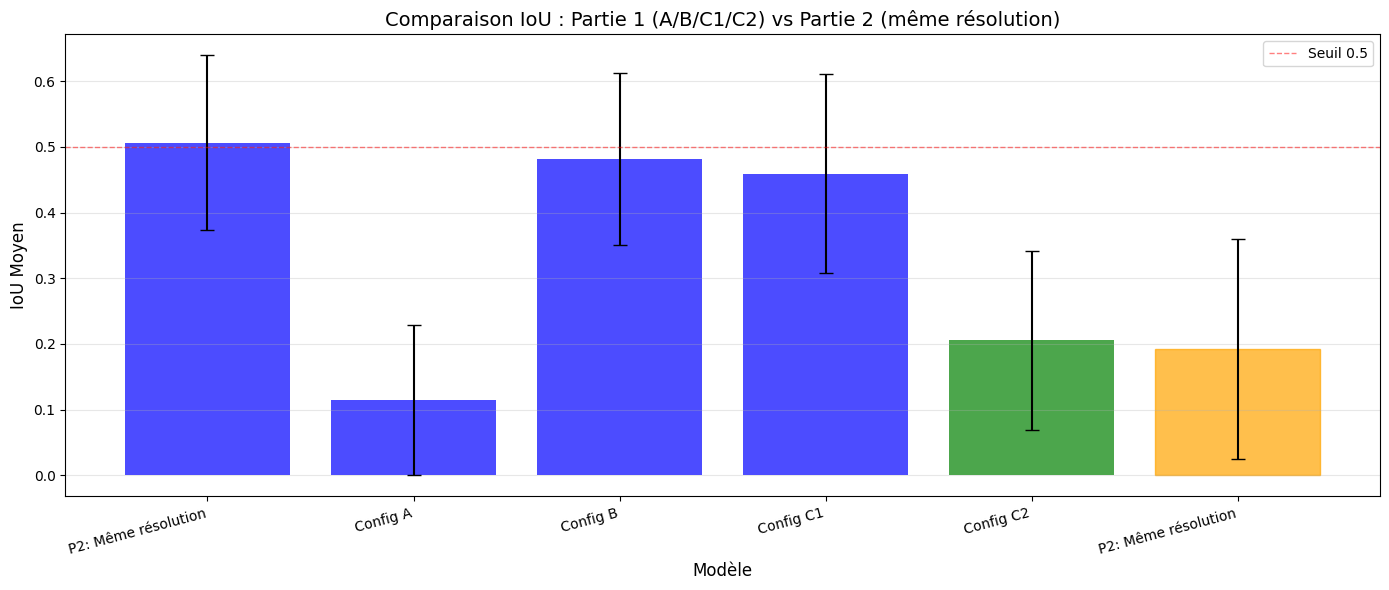

In [8]:

fig, ax = plt.subplots(figsize=(14, 6))


models = df_results["Modèle"]
means = df_results["Moyenne IoU"]
stds = df_results["Écart-type IoU"]


x_pos = np.arange(len(models))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color=['blue', 'blue', 'blue', 'blue', 'green'])


bars[-1].set_color('orange')


ax.set_xlabel("Modèle", fontsize=12)
ax.set_ylabel("IoU Moyen", fontsize=12)
ax.set_title("Comparaison IoU : Partie 1 (A/B/C1/C2) vs Partie 2 (même résolution)", fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels([m.replace("Partie 1 - ", "").replace("Partie 2 - ", "P2: ") for m in models], 
                    rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)


ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Seuil 0.5')
ax.legend()

plt.tight_layout()
plt.savefig("results/part4_iou_comparison.png", dpi=150, bbox_inches="tight")
print(" Graphique sauvegardé: results/part4_iou_comparison.png")
plt.show()

## 9. Exemples visuels de heatmaps

Afficher quelques exemples de heatmaps pour chaque modèle.

In [9]:

n_samples = 2
samples_per_model = {}


for model_config in models_config:
    model = load_model(model_config)
    if model is None:
        continue
    
    samples = []
    with torch.no_grad():
        for batch in val_loader:
            if len(samples) >= n_samples:
                break
            
            try:
                heatmap, _ = generate_heatmap_for_sample(model, batch, device)
                
                for i in range(min(batch["original"].shape[0], n_samples - len(samples))):
                    samples.append({
                        "image": batch["original"][i].cpu(),
                        "heatmap": heatmap[i].cpu(),
                        "mask": batch["mask"][i].cpu(),
                    })
            except:
                continue
    
    samples_per_model[model_config["name"]] = samples

print(f" Exemples collectés pour {len(samples_per_model)} modèles")

  ✅ Partie 2 - Même résolution chargé (F1: 0.8241)
  ✅ Partie 1 - Config A chargé (F1: 0.9749)
 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches
  ✅ Partie 1 - Config B chargé (F1: 0.9694)
 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches
  ✅ Partie 1 - Config C1 chargé (F1: 0.9592)
 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches
  ✅ Partie 1 - Config C2 chargé (F1: 0.9751)
 Détection CrossViT avec 2 branches : [197, 401]
 Utilisation de la branche Large avec 196 patches
  ✅ Partie 2 - Même résolution chargé (F1: 0.7982)
 Exemples collectés pour 5 modèles


 Exemples sauvegardés: results/part4_heatmap_examples.png


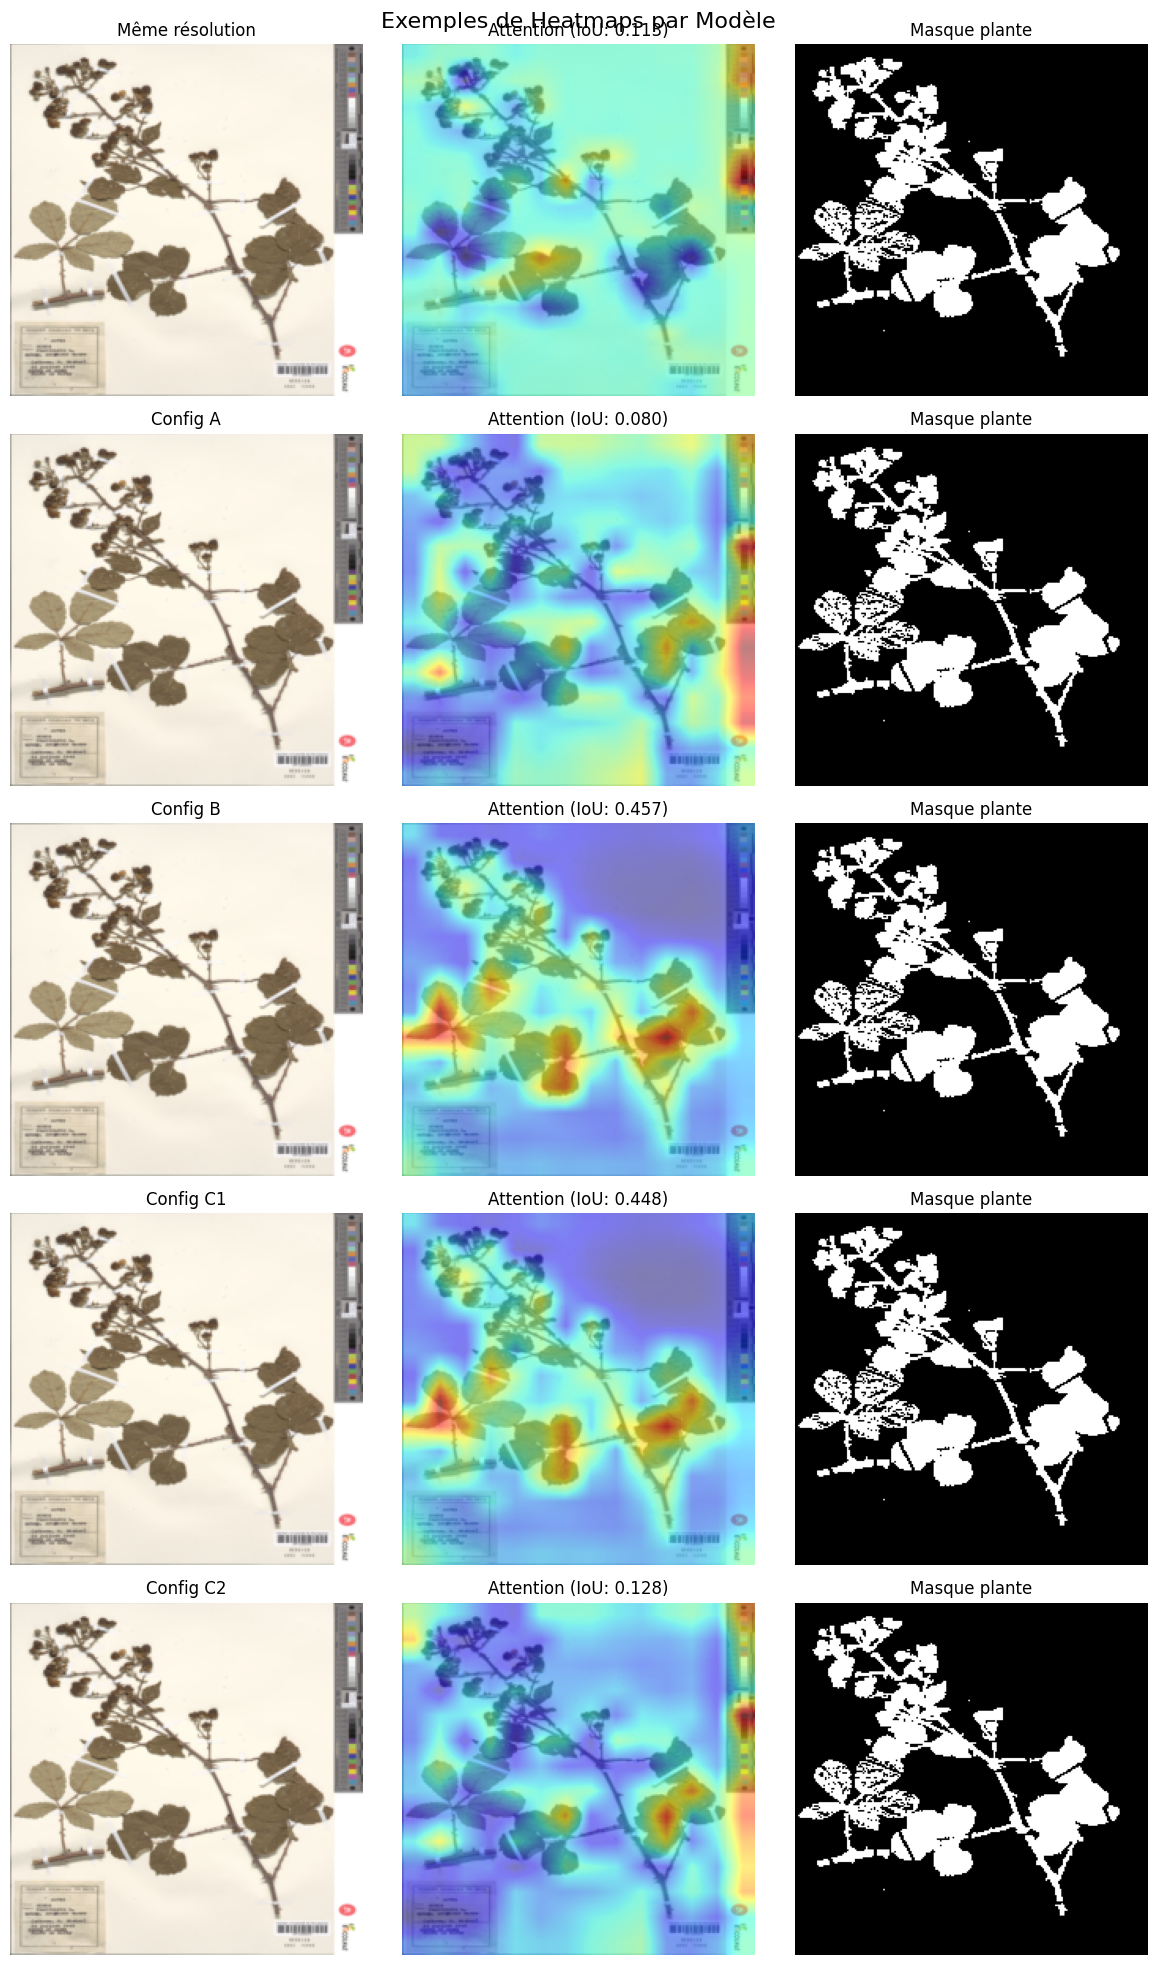

In [10]:

n_models = len(samples_per_model)
fig, axes = plt.subplots(n_models, 3, figsize=(12, 4 * n_models))

if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, samples) in enumerate(samples_per_model.items()):
    if not samples:
        continue
    
    sample = samples[0]  
    
    
    mean = torch.tensor(config.IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(config.IMAGENET_STD).view(3, 1, 1)
    img = sample["image"] * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    heatmap = sample["heatmap"].numpy()
    mask = sample["mask"].squeeze().numpy()
    
    iou = compute_iou(torch.tensor(heatmap), torch.tensor(mask)).item()
    
   
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"{model_name.split(' - ')[1] if ' - ' in model_name else model_name}")
    axes[idx, 0].axis("off")
    
   
    axes[idx, 1].imshow(img)
    axes[idx, 1].imshow(heatmap, cmap="jet", alpha=0.5)
    axes[idx, 1].set_title(f"Attention (IoU: {iou:.3f})")
    axes[idx, 1].axis("off")
    
   
    axes[idx, 2].imshow(mask, cmap="gray")
    axes[idx, 2].set_title("Masque plante")
    axes[idx, 2].axis("off")

plt.suptitle("Exemples de Heatmaps par Modèle", fontsize=16)
plt.tight_layout()
plt.savefig("results/part4_heatmap_examples.png", dpi=150, bbox_inches="tight")
print(" Exemples sauvegardés: results/part4_heatmap_examples.png")
plt.show()